# Лабораторная работа №3. Проведение исследований с решающим деревом

## Создание бейзлайна и оценка качества

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix, 
                             mean_squared_error, mean_absolute_error, r2_score,
                             precision_score, recall_score, roc_curve)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif

from typing import Union, Any
import warnings

### Классификация

Загрузка датасета

In [2]:
df_class = pd.read_csv('datasets/online_shoppers_intention.csv')

Размер датасета

In [3]:
df_class.shape

(12330, 18)

Первые 5 строк

In [4]:
df_class.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Информация о данных

In [5]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Статистика по числовым признакам

In [6]:
df_class.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


Определение баланса классов

In [7]:
df_class['Revenue'].value_counts()

Revenue
False    10422
True      1908
Name: count, dtype: int64

Копирование датасета для его дальнейшего преобразования

In [8]:
df_class_clean = df_class.copy()

Кодирование категориальных признаков с помощью `LabelEncoder`

In [10]:
categorical_cols = df_class_clean.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_class_clean[col] = le.fit_transform(df_class_clean[col].astype(str))
    label_encoders[col] = le
    print(f"  Закодирована колонка: {col}")

  Закодирована колонка: Month
  Закодирована колонка: VisitorType


Выделение признаков и таргета, их разделение на выборки для обучения и тестирования

In [11]:
X = df_class_clean.drop('Revenue', axis=1)
y = df_class_clean['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nРазмеры выборок:")
print(f"  Обучающая выборка: {X_train.shape}")
print(f"  Тестовая выборка: {X_test.shape}")
print(f"  Распределение классов в train: {np.bincount(y_train)}")
print(f"  Распределение классов в test: {np.bincount(y_test)}")


Размеры выборок:
  Обучающая выборка: (8631, 17)
  Тестовая выборка: (3699, 17)
  Распределение классов в train: [7295 1336]
  Распределение классов в test: [3127  572]


Масштабирование данных с помощью `StandardScaler`

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучение модели классификации `DecisionTreeClassifier`

In [13]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train_scaled, y_train)

y_pred = tree_classifier.predict(X_test_scaled)
y_pred_proba = tree_classifier.predict_proba(X_test_scaled)[:, 1]

Вычисление метрик

Accuracy (точность): 0.8554
F1-Score: 0.5392
ROC-AUC: 0.7295

Матрица ошибок:
[[2851  276]
 [ 259  313]]


<Figure size 800x600 with 0 Axes>

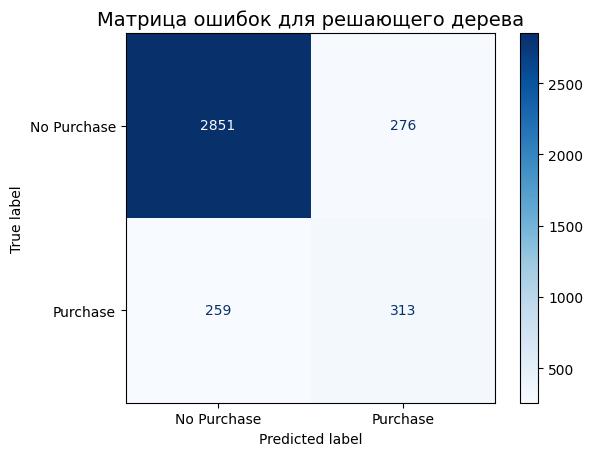

In [14]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy (точность): {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Визуализация матрицы ошибок

In [ ]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['No Purchase', 'Purchase'])
disp.plot(cmap='Blues')
plt.title('Матрица ошибок для решающего дерева', fontsize=14)
plt.show()

Дополнительная оценка результатов модели

In [15]:
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"  Precision: {precision:.3f}")
print(f"    - Из {TP+FP} предсказанных покупок, {TP} были верными")
print(f"  Recall: {recall:.3f}")
print(f"    - Из {TP+FN} реальных покупок, нашли {TP}")

1. Модель правильно предсказывает 85.5% всех сессий
2. F1-Score = 0.539 (баланс между точностью и полнотой)
3. ROC-AUC = 0.729 (чем ближе к 1, тем лучше модель различает классы)

Дополнительные метрики из матрицы ошибок:
  Precision (точность): 0.531
    - Из 589 предсказанных покупок, 313 были верными
  Recall (полнота): 0.547
    - Из 572 реальных покупок, нашли 313
  False Positive Rate: 0.088
  False Negative Rate: 0.453


### Регрессия

Загрузка датасета

In [16]:
df_reg = pd.read_csv('datasets/parkinsons.csv')

Размер датасета

In [17]:
df_reg.shape

(5875, 22)

Первые 5 строк

In [18]:
df_reg.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


Информация о данных

In [19]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

Статистика по числовым признакам

In [20]:
df_reg.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


Копирование датасета для его дальнейшего преобразования. Удаление столбца `subject#`, т.к. не несёт полезной информации

In [21]:
df_reg_clean = df_reg.copy()

df_reg_clean = df_reg_clean.drop('subject#', axis=1)

Выделение признаков и таргета, их разделение на выборки для обучения и тестирования

In [22]:
X = df_reg_clean.drop('total_UPDRS', axis=1)
y = df_reg_clean['total_UPDRS']

print(f"Количество признаков: {X.shape[1]}")
print(f"Диапазон целевой переменной: [{y.min():.2f}, {y.max():.2f}]")
print(f"Среднее значение целевой переменной: {y.mean():.2f}")
print(f"Стандартное отклонение целевой переменной: {y.std():.2f}")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\nРазмеры выборок:")
print(f"  Обучающая выборка: {X_train_reg.shape}")
print(f"  Тестовая выборка: {X_test_reg.shape}")

Количество признаков: 20
Диапазон целевой переменной: [7.00, 54.99]
Среднее значение целевой переменной: 29.02
Стандартное отклонение целевой переменной: 10.70


Масштабирование данных с помощью `StandardScaler`

In [24]:
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

Обучение модели регрессии `DecisionTreeRegressor`

In [25]:
tree_regressor = DecisionTreeRegressor(random_state=42)
tree_regressor.fit(X_train_reg_scaled, y_train_reg)

y_pred_reg = tree_regressor.predict(X_test_reg_scaled)

Вычисление метрик

MSE (среднеквадратичная ошибка): 0.6149
RMSE (корень из MSE): 0.7842
MAE (средняя абсолютная ошибка): 0.2016
R² (коэффициент детерминации): 0.9945


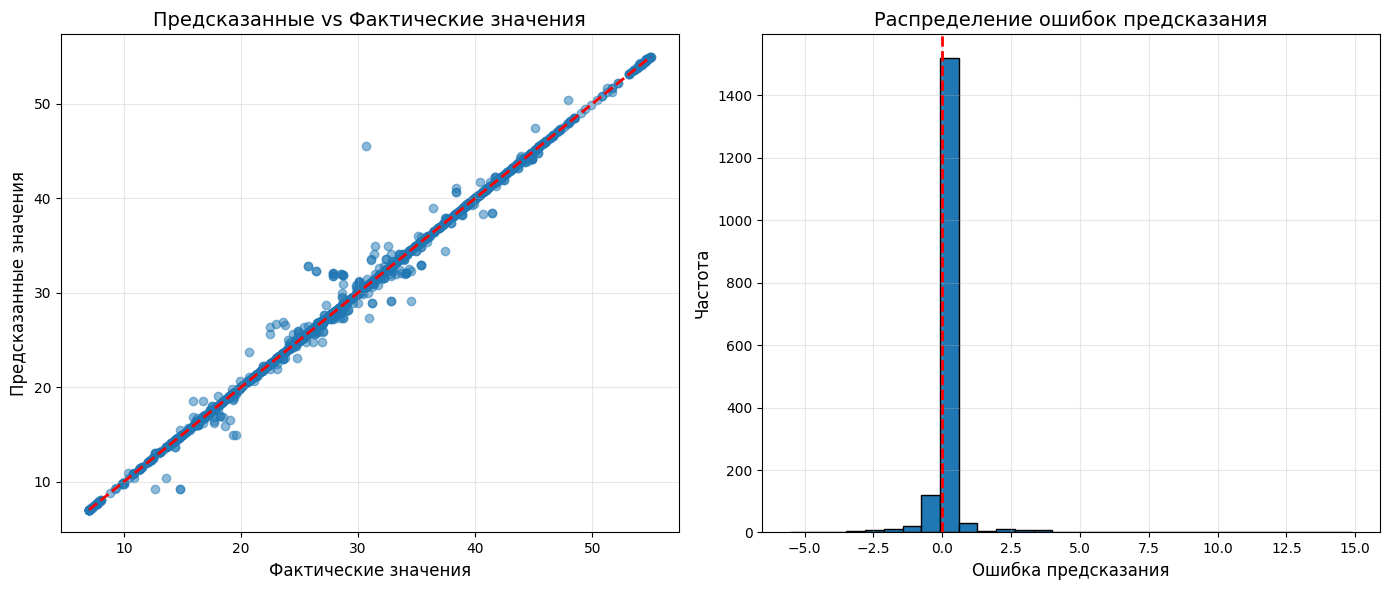

In [26]:
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

Визуализация предсказаний

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test_reg, y_pred_reg, alpha=0.5)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 
             'r--', lw=2)
axes[0].set_xlabel('Фактические значения', fontsize=12)
axes[0].set_ylabel('Предсказанные значения', fontsize=12)
axes[0].set_title('Предсказанные vs Фактические значения', fontsize=14)
axes[0].grid(True, alpha=0.3)

errors = y_pred_reg - y_test_reg
axes[1].hist(errors, bins=30, edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Ошибка предсказания', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)
axes[1].set_title('Распределение ошибок предсказания', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Результаты базовых моделей

In [28]:
print("\nКлассификация")
print("Метрики:")
print(f"- Accuracy: {accuracy:.4f}")
print(f"- F1-Score: {f1:.4f}")
print(f"- ROC-AUC:  {roc_auc:.4f}")

print("\nРегрессия")
print("Метрики:")
print(f"- MSE:  {mse:.4f}")
print(f"- RMSE: {rmse:.4f}")
print(f"- MAE:  {mae:.4f}")
print(f"- R²:   {r2:.4f}")


СВОДКА РЕЗУЛЬТАТОВ БЕЙЗЛАЙН МОДЕЛЕЙ РЕШАЮЩЕГО ДЕРЕВА

1. КЛАССИФИКАЦИЯ (Online Shoppers):
   Модель: DecisionTreeClassifier
   Метрики:
     - Accuracy: 0.8554
     - F1-Score: 0.5392
     - ROC-AUC:  0.7295

2. РЕГРЕССИЯ (Parkinson's Disease):
   Модель: DecisionTreeRegressor
   Метрики:
     - MSE:  0.6149
     - RMSE: 0.7842
     - MAE:  0.2016
     - R²:   0.9945


## Улучшение бейзлайна

### Классификация

Сохранение метрик базовой модели

In [29]:
class_base_metrics = {
    'Accuracy': accuracy,
    'F1': f1,
    'ROC-AUC': roc_auc,
    'Precision': precision,
    'Recall': recall
}

Функция сравнения метрик новой модели с базовой

In [30]:
def print_comparison_class(metrics_old, metrics_new):
    comparison_data = []
    for metric in ['Accuracy', 'F1', 'ROC-AUC', 'Precision', 'Recall']:
        base_val = metrics_old[metric]
        new_val = metrics_new[metric]
        diff = new_val - base_val
        change = "улучшение" if diff > 0 else "ухудшение"
        
        comparison_data.append({
            'Метрика': metric,
            'Базовая модель': f"{base_val:.4f}",
            'Новая модель': f"{new_val:.4f}",
            'Разница': f"{diff:+.4f}",
            'Изменение': change
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))

Повторное копирование, разделение и масштабирование данных

In [31]:
df_class_clean = df_class.copy()

categorical_cols = df_class_clean.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_class_clean[col] = le.fit_transform(df_class_clean[col].astype(str))
    label_encoders[col] = le

X = df_class_clean.drop('Revenue', axis=1)
y = df_class_clean['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Гипотеза 1: Ограничение глубины дерева и минимальное число выборок на листе

In [32]:
dt_depth = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)
dt_depth.fit(X_train_scaled, y_train)

y_pred_depth = dt_depth.predict(X_test_scaled)
y_pred_proba_depth = dt_depth.predict_proba(X_test_scaled)[:, 1]

metrics_depth = {
    'Accuracy': accuracy_score(y_test, y_pred_depth),
    'F1': f1_score(y_test, y_pred_depth),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_depth),
    'Precision': precision_score(y_test, y_pred_depth),
    'Recall': recall_score(y_test, y_pred_depth)
}

print("Ограничение глубины дерева (max_depth=10, min_samples_leaf=5)")
print_comparison_class(class_base_metrics, metrics_depth)

Ограничение глубины дерева (max_depth=10, min_samples_leaf=5)
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8554       0.8781 +0.0227 улучшение
       F1         0.5392       0.5659 +0.0267 улучшение
  ROC-AUC         0.7295       0.8550 +0.1255 улучшение
Precision         0.5314       0.6296 +0.0981 улучшение
   Recall         0.5472       0.5140 -0.0332 ухудшение


Гипотеза 2: Отбор признаков

In [33]:
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

dt_selected = DecisionTreeClassifier(random_state=42)
dt_selected.fit(X_train_selected, y_train)

y_pred_sel = dt_selected.predict(X_test_selected)
y_pred_proba_sel = dt_selected.predict_proba(X_test_selected)[:, 1]

metrics_sel = {
    'Accuracy': accuracy_score(y_test, y_pred_sel),
    'F1': f1_score(y_test, y_pred_sel),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_sel),
    'Precision': precision_score(y_test, y_pred_sel),
    'Recall': recall_score(y_test, y_pred_sel)
}

print("Отбор 10 лучших признаков")
print_comparison_class(class_base_metrics, metrics_sel)

Отбор 10 лучших признаков
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8554       0.8489 -0.0065 ухудшение
       F1         0.5392       0.5143 -0.0249 ухудшение
  ROC-AUC         0.7295       0.7027 -0.0268 ухудшение
Precision         0.5314       0.5112 -0.0202 ухудшение
   Recall         0.5472       0.5175 -0.0297 ухудшение


Гипотеза 3: Добавление полиномиальных признаков

In [34]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Исходное количество признаков: {X_train_scaled.shape[1]}")
print(f"Количество признаков с полиномиальными: {X_train_poly.shape[1]}")

dt_poly = DecisionTreeClassifier(random_state=42)
dt_poly.fit(X_train_poly, y_train)

y_pred_poly = dt_poly.predict(X_test_poly)
y_pred_proba_poly = dt_poly.predict_proba(X_test_poly)[:, 1]

metrics_poly = {
    'Accuracy': accuracy_score(y_test, y_pred_poly),
    'F1': f1_score(y_test, y_pred_poly),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_poly),
    'Precision': precision_score(y_test, y_pred_poly),
    'Recall': recall_score(y_test, y_pred_poly)
}

print("Полиномиальные признаки")
print_comparison_class(class_base_metrics, metrics_poly)

Исходное количество признаков: 17
Количество признаков с полиномиальными: 153
Полиномиальные признаки (степень 2)
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8554       0.8454 -0.0100 ухудшение
       F1         0.5392       0.5225 -0.0167 ухудшение
  ROC-AUC         0.7295       0.7236 -0.0059 ухудшение
Precision         0.5314       0.5000 -0.0314 ухудшение
   Recall         0.5472       0.5472 +0.0000 ухудшение
Полиномиальные признаки (степень 2)
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8554       0.8454 -0.0100 ухудшение
       F1         0.5392       0.5225 -0.0167 ухудшение
  ROC-AUC         0.7295       0.7236 -0.0059 ухудшение
Precision         0.5314       0.5000 -0.0314 ухудшение
   Recall         0.5472       0.5472 +0.0000 ухудшение


Гипотеза 4: Подбор гиперпараметров

In [35]:
warnings.filterwarnings('ignore')

param_grid = {
    'max_depth': [5, 8, 10, 12, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 5, 10],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42]
}

dt_gs = DecisionTreeClassifier()
random_search = RandomizedSearchCV(
    estimator=dt_gs, param_distributions=param_grid, n_iter=50, cv=5, 
    scoring='f1', random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

print("Лучшие параметры DecisionTree:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

best_dt = random_search.best_estimator_
y_pred_gs = best_dt.predict(X_test_scaled)
y_pred_proba_gs = best_dt.predict_proba(X_test_scaled)[:, 1]

metrics_gs = {
    'Accuracy': accuracy_score(y_test, y_pred_gs),
    'F1': f1_score(y_test, y_pred_gs),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_gs),
    'Precision': precision_score(y_test, y_pred_gs),
    'Recall': recall_score(y_test, y_pred_gs)
}

print("Подбор гиперпараметров")
print_comparison_class(class_base_metrics, metrics_gs)

Лучшие параметры DecisionTree:
  splitter: best
  random_state: 42
  min_samples_split: 20
  min_samples_leaf: 10
  max_features: sqrt
  max_depth: 12
  criterion: gini
Подбор гиперпараметров
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8554       0.8786 +0.0232 улучшение
       F1         0.5392       0.5559 +0.0167 улучшение
  ROC-AUC         0.7295       0.8750 +0.1455 улучшение
Precision         0.5314       0.6401 +0.1087 улучшение
   Recall         0.5472       0.4913 -0.0559 ухудшение


Формирование улучшенной модели и её обучение

In [36]:
best_params = random_search.best_params_.copy()

improved_dt = DecisionTreeClassifier(**best_params)
improved_dt.fit(X_train_scaled, y_train)

y_pred_improved = improved_dt.predict(X_test_scaled)
y_pred_proba_improved = improved_dt.predict_proba(X_test_scaled)[:, 1]

Метрики улучшенной модели

In [37]:
class_improved_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_improved),
    'F1': f1_score(y_test, y_pred_improved),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_improved),
    'Precision': precision_score(y_test, y_pred_improved),
    'Recall': recall_score(y_test, y_pred_improved)
}

for metric, value in class_improved_metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.8786
F1: 0.5559
ROC-AUC: 0.8750
Precision: 0.6401
Recall: 0.4913


Сравнение улучшенной модели с базовой

In [38]:
print_comparison_class(class_base_metrics, class_improved_metrics)

  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8554       0.8786 +0.0232 улучшение
       F1         0.5392       0.5559 +0.0167 улучшение
  ROC-AUC         0.7295       0.8750 +0.1455 улучшение
Precision         0.5314       0.6401 +0.1087 улучшение
   Recall         0.5472       0.4913 -0.0559 ухудшение


Визуальное сравнение базовой и улучшенной модели

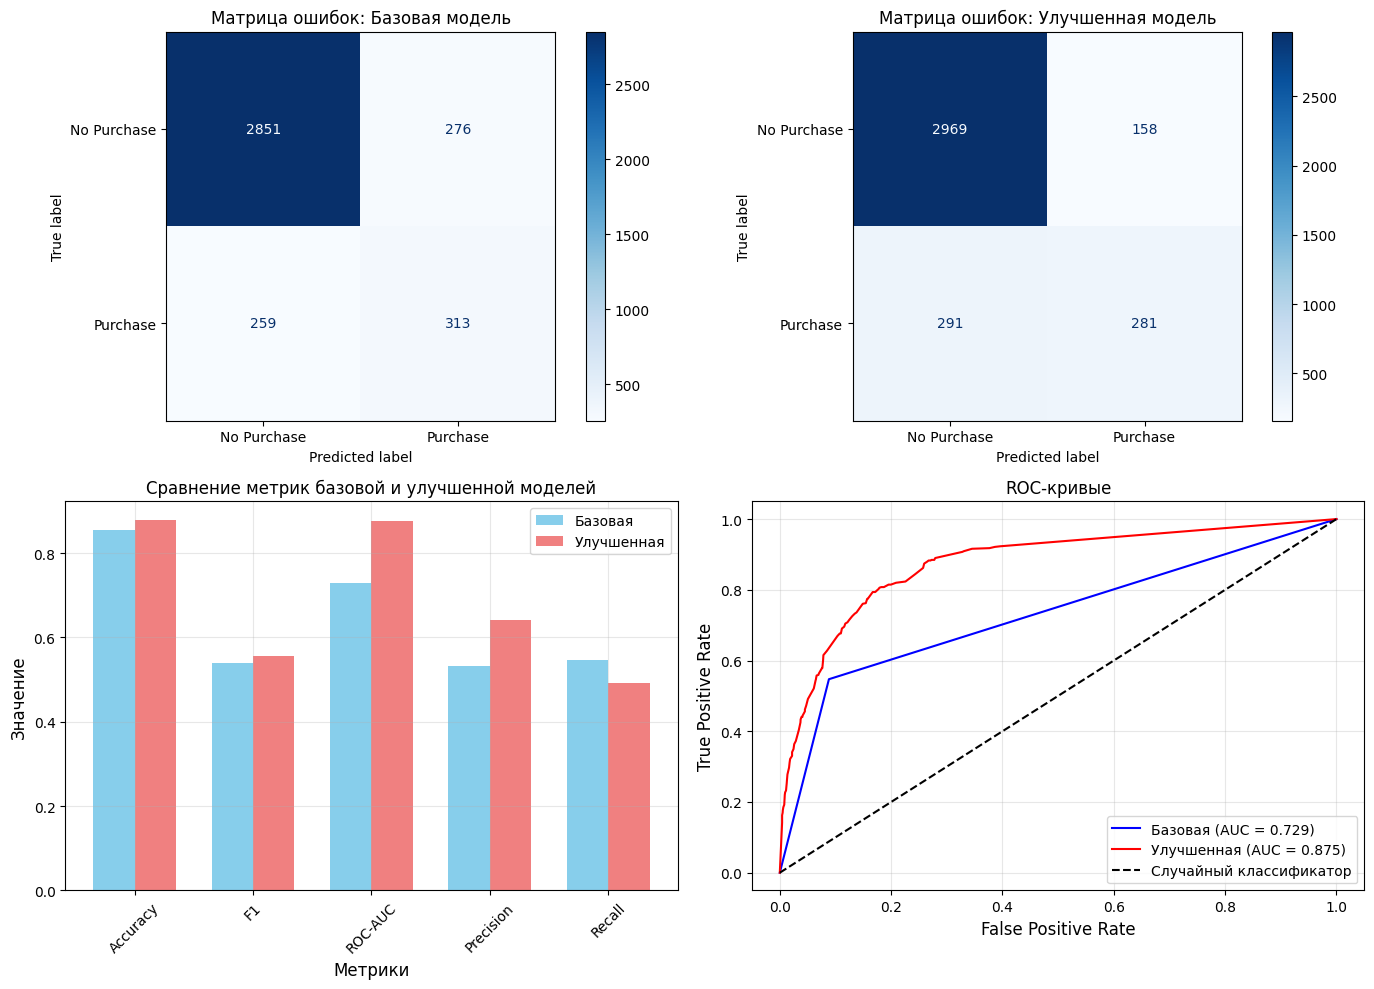

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].set_title('Матрица ошибок: Базовая модель', fontsize=12)
cm_base = confusion_matrix(y_test, y_pred)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, 
                                  display_labels=['No Purchase', 'Purchase'])
disp_base.plot(ax=axes[0, 0], cmap='Blues')

axes[0, 1].set_title('Матрица ошибок: Улучшенная модель', fontsize=12)
cm_improved = confusion_matrix(y_test, y_pred_improved)
disp_improved = ConfusionMatrixDisplay(confusion_matrix=cm_improved, 
                                       display_labels=['No Purchase', 'Purchase'])
disp_improved.plot(ax=axes[0, 1], cmap='Blues')

metrics_names = ['Accuracy', 'F1', 'ROC-AUC', 'Precision', 'Recall']
base_values = [class_base_metrics[m] for m in metrics_names]
improved_values = [class_improved_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 0].bar(x - width/2, base_values, width, label='Базовая', color='skyblue')
axes[1, 0].bar(x + width/2, improved_values, width, label='Улучшенная', color='lightcoral')
axes[1, 0].set_xlabel('Метрики', fontsize=12)
axes[1, 0].set_ylabel('Значение', fontsize=12)
axes[1, 0].set_title('Сравнение метрик базовой и улучшенной моделей', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_names, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba)
fpr_improved, tpr_improved, _ = roc_curve(y_test, y_pred_proba_improved)

axes[1, 1].plot(fpr_base, tpr_base, label=f'Базовая (AUC = {roc_auc:.3f})', color='blue')
axes[1, 1].plot(fpr_improved, tpr_improved, label=f'Улучшенная (AUC = {class_improved_metrics["ROC-AUC"]:.3f})', color='red')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
axes[1, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[1, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[1, 1].set_title('ROC-кривые', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Анализ результатов классификации

In [40]:
TN_base, FP_base, FN_base, TP_base = cm_base.ravel()
TN_imp, FP_imp, FN_imp, TP_imp = cm_improved.ravel()

print("\n1. Анализ обнаружения покупок:")
print(f"   Базовая модель нашла {TP_base} из {TP_base + FN_base} реальных покупок")
print(f"   Улучшенная модель нашла {TP_imp} из {TP_imp + FN_imp} реальных покупок")
print(f"   Улучшение в обнаружении покупок: {TP_imp - TP_base} реальных покупок")
print(f"   Процентное улучшение Recall: {((TP_imp / (TP_imp + FN_imp)) - (TP_base / (TP_base + FN_base))) * 100:+.1f}%")

print("\n2. Анализ ложных срабатываний:")
print(f"   Базовая модель: {FP_base} ложных предсказаний покупки")
print(f"   Улучшенная модель: {FP_imp} ложных предсказаний покупки")
print(f"   Изменение: {FP_imp - FP_base} дополнительных ложных срабатываний")


1. Анализ обнаружения покупок:
   Базовая модель нашла 313 из 572 реальных покупок
   Улучшенная модель нашла 281 из 572 реальных покупок
   Улучшение в обнаружении покупок: -32 реальных покупок
   Процентное улучшение Recall: -5.6%

2. Анализ ложных срабатываний:
   Базовая модель: 276 ложных предсказаний покупки
   Улучшенная модель: 158 ложных предсказаний покупки
   Изменение: -118 дополнительных ложных срабатываний


### Регрессия

Сохранение метрик базовой модели

In [41]:
reg_base_metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R²': r2
}

Функция сравнения метрик новой модели с базовой

In [42]:
def print_comparison_reg(metrics_old, metrics_new):
    comparison_data = []
    for metric in ['MSE', 'RMSE', 'MAE', 'R²']:
        base_val = metrics_old[metric]
        new_val = metrics_new[metric]
        diff = new_val - base_val
        if metric == 'R²':
            change = "улучшение" if diff > 0 else "ухудшение"
        else:
            change = "улучшение" if diff < 0 else "ухудшение"
        
        comparison_data.append({
            'Метрика': metric,
            'Базовая модель': f"{base_val:.4f}",
            'Новая модель': f"{new_val:.4f}",
            'Разница': f"{diff:+.4f}",
            'Изменение': change
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))

Повторное копирование и подготовка данных

In [43]:
df_reg_clean = df_reg.copy()
df_reg_clean = df_reg_clean.drop('subject#', axis=1)

X = df_reg_clean.drop('total_UPDRS', axis=1)
y = df_reg_clean['total_UPDRS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Гипотеза 1: Ограничение глубины дерева

In [44]:
dt_reg_depth = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, random_state=42)
dt_reg_depth.fit(X_train_scaled, y_train)
y_pred_depth = dt_reg_depth.predict(X_test_scaled)

metrics_depth = {
    'MSE': mean_squared_error(y_test, y_pred_depth),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_depth)),
    'MAE': mean_absolute_error(y_test, y_pred_depth),
    'R²': r2_score(y_test, y_pred_depth)
}

print("Ограничение глубины дерева (max_depth=10, min_samples_leaf=5)")
print_comparison_reg(reg_base_metrics, metrics_depth)

Ограничение глубины дерева (max_depth=10, min_samples_leaf=5)
Метрика Базовая модель Новая модель Разница Изменение
    MSE         0.6149       0.8641 +0.2491 ухудшение
   RMSE         0.7842       0.9295 +0.1454 ухудшение
    MAE         0.2016       0.4936 +0.2920 ухудшение
     R²         0.9945       0.9923 -0.0022 ухудшение


Гипотеза 2: Обработка выбросов с помощью RobustScaler

In [45]:
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train)
X_test_robust = robust_scaler.transform(X_test)

dt_reg_robust = DecisionTreeRegressor(random_state=42)
dt_reg_robust.fit(X_train_robust, y_train)
y_pred_robust = dt_reg_robust.predict(X_test_robust)

metrics_robust = {
    'MSE': mean_squared_error(y_test, y_pred_robust),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_robust)),
    'MAE': mean_absolute_error(y_test, y_pred_robust),
    'R²': r2_score(y_test, y_pred_robust)
}

print("RobustScaler (устойчивое масштабирование)")
print_comparison_reg(reg_base_metrics, metrics_robust)

RobustScaler (устойчивое масштабирование)
Метрика Базовая модель Новая модель Разница Изменение
    MSE         0.6149       0.6149 +0.0000 ухудшение
   RMSE         0.7842       0.7842 +0.0000 ухудшение
    MAE         0.2016       0.2016 +0.0000 ухудшение
     R²         0.9945       0.9945 +0.0000 ухудшение


Гипотеза 3: Логарифмическое преобразование целевой переменной

In [46]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

dt_reg_log = DecisionTreeRegressor(random_state=42)
dt_reg_log.fit(X_train_scaled, y_train_log)
y_pred_log = dt_reg_log.predict(X_test_scaled)

y_pred_exp = np.expm1(y_pred_log)

metrics_log = {
    'MSE': mean_squared_error(y_test, y_pred_exp),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_exp)),
    'MAE': mean_absolute_error(y_test, y_pred_exp),
    'R²': r2_score(y_test, y_pred_exp)
}

print("Логарифмирование целевой переменной")
print_comparison_reg(reg_base_metrics, metrics_log)

Логарифмирование целевой переменной
Метрика Базовая модель Новая модель Разница Изменение
    MSE         0.6149       0.3479 -0.2670 улучшение
   RMSE         0.7842       0.5899 -0.1943 улучшение
    MAE         0.2016       0.1355 -0.0661 улучшение
     R²         0.9945       0.9969 +0.0024 улучшение


Гипотеза 4: Подбор гиперпараметров

In [47]:
warnings.filterwarnings('ignore')

param_grid_reg = {
    'max_depth': [5, 8, 10, 12, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 5, 10],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42]
}

dt_gs_reg = DecisionTreeRegressor()
random_search_reg = RandomizedSearchCV(
    estimator=dt_gs_reg, param_distributions=param_grid_reg, n_iter=50, cv=5, 
    scoring='r2', random_state=42, n_jobs=-1
)
random_search_reg.fit(X_train_scaled, y_train)

print("Лучшие параметры DecisionTree (регрессия):")
for param, value in random_search_reg.best_params_.items():
    print(f"  {param}: {value}")

best_dt_reg = random_search_reg.best_estimator_
y_pred_gs_reg = best_dt_reg.predict(X_test_scaled)

metrics_gs_reg = {
    'MSE': mean_squared_error(y_test, y_pred_gs_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gs_reg)),
    'MAE': mean_absolute_error(y_test, y_pred_gs_reg),
    'R²': r2_score(y_test, y_pred_gs_reg)
}

print("Подбор гиперпараметров")
print_comparison_reg(reg_base_metrics, metrics_gs_reg)

Лучшие параметры DecisionTree (регрессия):
  splitter: best
  random_state: 42
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: None
  max_depth: 12
  criterion: squared_error
Подбор гиперпараметров
Метрика Базовая модель Новая модель Разница Изменение
    MSE         0.6149       0.5519 -0.0630 улучшение
   RMSE         0.7842       0.7429 -0.0413 улучшение
    MAE         0.2016       0.2639 +0.0623 ухудшение
     R²         0.9945       0.9951 +0.0006 улучшение


Формирование улучшенной модели и её обучение

In [48]:
best_params_reg = random_search_reg.best_params_.copy()

improved_dt_reg = DecisionTreeRegressor(**best_params_reg)
improved_dt_reg.fit(X_train_scaled, y_train)

y_pred_improved_reg = improved_dt_reg.predict(X_test_scaled)

Метрики улучшенной модели

In [49]:
reg_improved_metrics = {
    'MSE': mean_squared_error(y_test, y_pred_improved_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_improved_reg)),
    'MAE': mean_absolute_error(y_test, y_pred_improved_reg),
    'R²': r2_score(y_test, y_pred_improved_reg)
}

for metric, value in reg_improved_metrics.items():
    print(f"{metric}: {value:.4f}")

MSE: 0.5519
RMSE: 0.7429
MAE: 0.2639
R²: 0.9951


Сравнение улучшенной модели с базовой

In [50]:
print_comparison_reg(reg_base_metrics, reg_improved_metrics)

Метрика Базовая модель Новая модель Разница Изменение
    MSE         0.6149       0.5519 -0.0630 улучшение
   RMSE         0.7842       0.7429 -0.0413 улучшение
    MAE         0.2016       0.2639 +0.0623 ухудшение
     R²         0.9945       0.9951 +0.0006 улучшение


Визуальное сравнение базовой и улучшенной модели

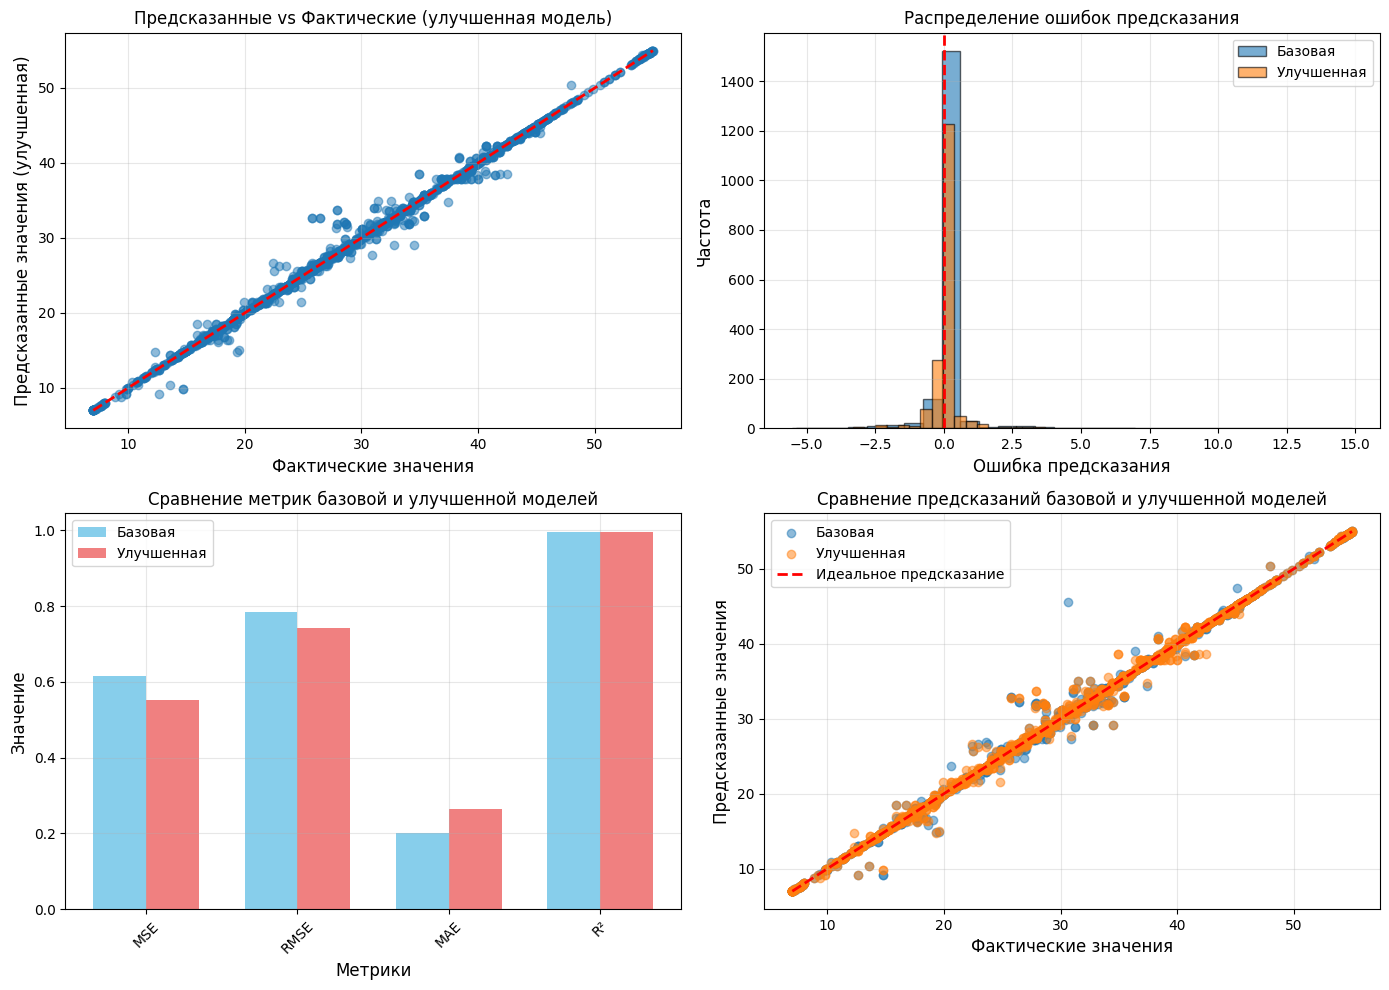

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_test, y_pred_improved_reg, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[0, 0].set_xlabel('Фактические значения', fontsize=12)
axes[0, 0].set_ylabel('Предсказанные значения (улучшенная)', fontsize=12)
axes[0, 0].set_title('Предсказанные vs Фактические (улучшенная модель)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

errors_base = y_pred_reg - y_test
errors_imp = y_pred_improved_reg - y_test

axes[0, 1].hist(errors_base, bins=30, alpha=0.6, label='Базовая', edgecolor='black')
axes[0, 1].hist(errors_imp, bins=30, alpha=0.6, label='Улучшенная', edgecolor='black')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Ошибка предсказания', fontsize=12)
axes[0, 1].set_ylabel('Частота', fontsize=12)
axes[0, 1].set_title('Распределение ошибок предсказания', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

metrics_names = ['MSE', 'RMSE', 'MAE', 'R²']
base_values = [reg_base_metrics[m] for m in metrics_names]
improved_values = [reg_improved_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 0].bar(x - width/2, base_values, width, label='Базовая', color='skyblue')
axes[1, 0].bar(x + width/2, improved_values, width, label='Улучшенная', color='lightcoral')
axes[1, 0].set_xlabel('Метрики', fontsize=12)
axes[1, 0].set_ylabel('Значение', fontsize=12)
axes[1, 0].set_title('Сравнение метрик базовой и улучшенной моделей', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_names, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test, y_pred_reg, alpha=0.5, label='Базовая')
axes[1, 1].scatter(y_test, y_pred_improved_reg, alpha=0.5, label='Улучшенная')
axes[1, 1].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Идеальное предсказание')
axes[1, 1].set_xlabel('Фактические значения', fontsize=12)
axes[1, 1].set_ylabel('Предсказанные значения', fontsize=12)
axes[1, 1].set_title('Сравнение предсказаний базовой и улучшенной моделей', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Имплементация алгоритма машинного обучения

### Классификация

Кастомная модель дерева решений для классификации

In [52]:
class CustomDecisionTreeClassifier:
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None
        
    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, 
                     value=None, samples=None, impurity=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.samples = samples
            self.impurity = impurity
    
    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1.0 - np.sum(probabilities ** 2)
        return gini
    
    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-15))
        return entropy
    
    def _calculate_impurity(self, y):
        if self.criterion == 'gini':
            return self._gini(y)
        else:
            return self._entropy(y)
    
    def _information_gain(self, parent, left_child, right_child):
        n = len(parent)
        n_left = len(left_child)
        n_right = len(right_child)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        parent_impurity = self._calculate_impurity(parent)
        left_impurity = self._calculate_impurity(left_child)
        right_impurity = self._calculate_impurity(right_child)
        
        child_impurity = (n_left / n) * left_impurity + (n_right / n) * right_impurity
        information_gain = parent_impurity - child_impurity
        
        return information_gain
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue
                
                information_gain = self._information_gain(y, y[left_mask], y[right_mask])
                
                if information_gain > best_gain:
                    best_gain = information_gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_classes = len(np.unique(y))
        
        if (self.max_depth is not None and depth >= self.max_depth or
            n_samples < self.min_samples_split or
            n_classes == 1):
            
            value = np.bincount(y.astype(int), minlength=2)
            return self.Node(value=value, samples=n_samples, 
                           impurity=self._calculate_impurity(y))
        
        best_feature, best_threshold = self._best_split(X, y)
        
        if best_feature is None:
            value = np.bincount(y.astype(int), minlength=2)
            return self.Node(value=value, samples=n_samples, 
                           impurity=self._calculate_impurity(y))
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return self.Node(feature=best_feature, threshold=best_threshold,
                        left=left_subtree, right=right_subtree,
                        samples=n_samples, impurity=self._calculate_impurity(y))
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
        return self
    
    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    
    def predict_proba(self, X):
        probabilities = []
        for x in X:
            counts = self._traverse_tree(x, self.tree)
            proba = counts / counts.sum()
            probabilities.append(proba)
        
        return np.array(probabilities)
    
    def predict(self, X):
        predictions = []
        for x in X:
            counts = self._traverse_tree(x, self.tree)
            prediction = np.argmax(counts)
            predictions.append(prediction)
        
        return np.array(predictions)

Повторное копирование и разбиение данных

In [53]:
df_class_clean = df_class.copy()

categorical_cols = df_class_clean.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_class_clean[col] = le.fit_transform(df_class_clean[col].astype(str))
    label_encoders[col] = le

X_class = df_class_clean.drop('Revenue', axis=1)
y_class = df_class_clean['Revenue']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)

scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)

Обучение кастомного дерева решений (базовое)

In [54]:
custom_dt = CustomDecisionTreeClassifier(criterion='gini')
custom_dt.fit(X_train_class_scaled, y_train_class.values)

y_pred_custom = custom_dt.predict(X_test_class_scaled)
y_pred_proba_custom = custom_dt.predict_proba(X_test_class_scaled)[:, 1]

Метрики кастомного дерева решений

In [55]:
custom_class_base_metrics = {
    'Accuracy': accuracy_score(y_test_class, y_pred_custom),
    'F1': f1_score(y_test_class, y_pred_custom),
    'ROC-AUC': roc_auc_score(y_test_class, y_pred_proba_custom),
    'Precision': precision_score(y_test_class, y_pred_custom),
    'Recall': recall_score(y_test_class, y_pred_custom)
}

for metric, value in custom_class_base_metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.8486
F1: 0.5189
ROC-AUC: 0.7176
Precision: 0.5101
Recall: 0.5280


Сравнение кастомной модели с базовой из sklearn

In [56]:
print_comparison_class(class_base_metrics, custom_class_base_metrics)

  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8554       0.8486 -0.0068 ухудшение
       F1         0.5392       0.5189 -0.0203 ухудшение
  ROC-AUC         0.7295       0.7176 -0.0119 ухудшение
Precision         0.5314       0.5101 -0.0213 ухудшение
   Recall         0.5472       0.5280 -0.0192 ухудшение


Обучение улучшенного кастомного дерева решений

In [57]:
improved_custom_dt = CustomDecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='entropy'
)
improved_custom_dt.fit(X_train_class_scaled, y_train_class.values)

y_pred_imp_custom = improved_custom_dt.predict(X_test_class_scaled)
y_pred_proba_imp_custom = improved_custom_dt.predict_proba(X_test_class_scaled)[:, 1]

Метрики улучшенного кастомного дерева решений

In [58]:
custom_improved_metrics = {
    'Accuracy': accuracy_score(y_test_class, y_pred_imp_custom),
    'F1': f1_score(y_test_class, y_pred_imp_custom),
    'ROC-AUC': roc_auc_score(y_test_class, y_pred_proba_imp_custom),
    'Precision': precision_score(y_test_class, y_pred_imp_custom),
    'Recall': recall_score(y_test_class, y_pred_imp_custom)
}

for metric, value in custom_improved_metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.8759
F1: 0.5565
ROC-AUC: 0.8318
Precision: 0.6220
Recall: 0.5035


Сравнение улучшенной кастомной модели с улучшенной из sklearn

In [59]:
print_comparison_class(class_improved_metrics, custom_improved_metrics)

  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8786       0.8759 -0.0027 ухудшение
       F1         0.5559       0.5565 +0.0006 улучшение
  ROC-AUC         0.8750       0.8318 -0.0432 ухудшение
Precision         0.6401       0.6220 -0.0181 ухудшение
   Recall         0.4913       0.5035 +0.0122 улучшение


Итоговое сравнение всех моделей классификации

In [60]:
summary_class = pd.DataFrame({
    'Тип модели': ['Базовая (sklearn)', 'Улучшенная (sklearn)', 'Кастомная (базовая)', 'Кастомная (улучшенная)'],
    'Accuracy': [class_base_metrics['Accuracy'], class_improved_metrics['Accuracy'], custom_class_base_metrics['Accuracy'], custom_improved_metrics['Accuracy']],
    'F1-Score': [class_base_metrics['F1'], class_improved_metrics['F1'], custom_class_base_metrics['F1'], custom_improved_metrics['F1']],
    'ROC-AUC': [class_base_metrics['ROC-AUC'], class_improved_metrics['ROC-AUC'], custom_class_base_metrics['ROC-AUC'], custom_improved_metrics['ROC-AUC']],
    'Recall': [class_base_metrics['Recall'], class_improved_metrics['Recall'], custom_class_base_metrics['Recall'], custom_improved_metrics['Recall']]
})

print("Сводная таблица моделей классификации")
print(summary_class.to_string(index=False))

Сводная таблица моделей классификации
            Тип модели  Accuracy  F1-Score  ROC-AUC   Recall
     Базовая (sklearn)  0.855366  0.539190 0.729470 0.547203
  Улучшенная (sklearn)  0.878616  0.555885 0.874990 0.491259
   Кастомная (базовая)  0.848608  0.518900 0.717616 0.527972
Кастомная (улучшенная)  0.875912  0.556522 0.831831 0.503497


Визуализация сравнения всех моделей классификации

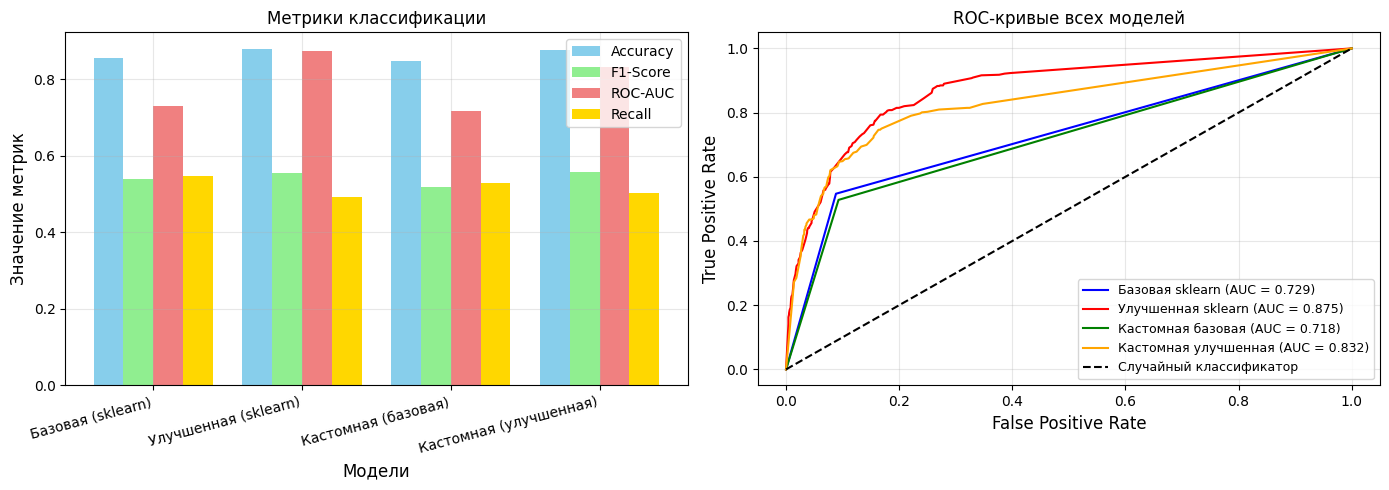

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(summary_class))
width = 0.2

axes[0].bar(x - width*1.5, summary_class['Accuracy'], width, label='Accuracy', color='skyblue')
axes[0].bar(x - width/2, summary_class['F1-Score'], width, label='F1-Score', color='lightgreen')
axes[0].bar(x + width/2, summary_class['ROC-AUC'], width, label='ROC-AUC', color='lightcoral')
axes[0].bar(x + width*1.5, summary_class['Recall'], width, label='Recall', color='gold')
axes[0].set_xlabel('Модели', fontsize=12)
axes[0].set_ylabel('Значение метрик', fontsize=12)
axes[0].set_title('Метрики классификации', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(summary_class['Тип модели'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

fpr_custom, tpr_custom, _ = roc_curve(y_test_class, y_pred_proba_custom)
fpr_improved_custom, tpr_improved_custom, _ = roc_curve(y_test_class, y_pred_proba_imp_custom)

axes[1].plot(fpr_base, tpr_base, label=f'Базовая sklearn (AUC = {class_base_metrics["ROC-AUC"]:.3f})', color='blue')
axes[1].plot(fpr_improved, tpr_improved, label=f'Улучшенная sklearn (AUC = {class_improved_metrics["ROC-AUC"]:.3f})', color='red')
axes[1].plot(fpr_custom, tpr_custom, label=f'Кастомная базовая (AUC = {custom_class_base_metrics["ROC-AUC"]:.3f})', color='green')
axes[1].plot(fpr_improved_custom, tpr_improved_custom, label=f'Кастомная улучшенная (AUC = {custom_improved_metrics["ROC-AUC"]:.3f})', color='orange')
axes[1].plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC-кривые всех моделей', fontsize=12)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Регрессия

Кастомная модель дерева решений для регрессии

In [62]:
class CustomDecisionTreeRegressor:
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='mse'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None
        
    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, 
                     value=None, samples=None, mse=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.samples = samples
            self.mse = mse
    
    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)
    
    def _mae(self, y):
        return np.mean(np.abs(y - np.median(y)))
    
    def _calculate_loss(self, y):
        if self.criterion == 'mse':
            return self._mse(y)
        else:
            return self._mae(y)
    
    def _mse_reduction(self, parent, left_child, right_child):
        n = len(parent)
        n_left = len(left_child)
        n_right = len(right_child)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        parent_mse = self._mse(parent)
        left_mse = self._mse(left_child)
        right_mse = self._mse(right_child)
        
        weighted_mse = (n_left / n) * left_mse + (n_right / n) * right_mse
        mse_reduction = parent_mse - weighted_mse
        
        return mse_reduction
    
    def _best_split(self, X, y):
        best_reduction = -1
        best_feature = None
        best_threshold = None
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue
                
                mse_reduction = self._mse_reduction(y, y[left_mask], y[right_mask])
                
                if mse_reduction > best_reduction:
                    best_reduction = mse_reduction
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        
        if (self.max_depth is not None and depth >= self.max_depth or
            n_samples < self.min_samples_split):
            
            return self.Node(value=np.mean(y), samples=n_samples, mse=self._mse(y))
        
        best_feature, best_threshold = self._best_split(X, y)
        
        if best_feature is None:
            return self.Node(value=np.mean(y), samples=n_samples, mse=self._mse(y))
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return self.Node(feature=best_feature, threshold=best_threshold,
                        left=left_subtree, right=right_subtree,
                        samples=n_samples, mse=self._mse(y))
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
        return self
    
    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    
    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self._traverse_tree(x, self.tree)
            predictions.append(prediction)
        
        return np.array(predictions)

Повторное копирование и подготовка данных для регрессии

In [63]:
df_reg_clean = df_reg.copy()
df_reg_clean = df_reg_clean.drop('subject#', axis=1)

X_reg = df_reg_clean.drop('total_UPDRS', axis=1)
y_reg = df_reg_clean['total_UPDRS']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

Обучение кастомного дерева решений (базовое)

In [64]:
custom_dt_reg = CustomDecisionTreeRegressor(criterion='mse')
custom_dt_reg.fit(X_train_reg_scaled, y_train_reg.values)

y_pred_custom_reg = custom_dt_reg.predict(X_test_reg_scaled)

Метрики кастомного дерева решений (регрессия)

In [65]:
custom_reg_base_metrics = {
    'MSE': mean_squared_error(y_test_reg, y_pred_custom_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_custom_reg)),
    'MAE': mean_absolute_error(y_test_reg, y_pred_custom_reg),
    'R²': r2_score(y_test_reg, y_pred_custom_reg)
}

for metric, value in custom_reg_base_metrics.items():
    print(f"{metric}: {value:.4f}")

MSE: 0.4663
RMSE: 0.6829
MAE: 0.1620
R²: 0.9959


Сравнение кастомной модели с базовой из sklearn

In [66]:
print_comparison_reg(reg_base_metrics, custom_reg_base_metrics)

Метрика Базовая модель Новая модель Разница Изменение
    MSE         0.6149       0.4663 -0.1486 улучшение
   RMSE         0.7842       0.6829 -0.1013 улучшение
    MAE         0.2016       0.1620 -0.0396 улучшение
     R²         0.9945       0.9959 +0.0013 улучшение


Обучение улучшенного кастомного дерева решений

In [67]:
improved_custom_dt_reg = CustomDecisionTreeRegressor(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='mse'
)
improved_custom_dt_reg.fit(X_train_reg_scaled, y_train_reg.values)

y_pred_imp_custom_reg = improved_custom_dt_reg.predict(X_test_reg_scaled)

Метрики улучшенного кастомного дерева решений

In [68]:
custom_reg_improved_metrics = {
    'MSE': mean_squared_error(y_test_reg, y_pred_imp_custom_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_imp_custom_reg)),
    'MAE': mean_absolute_error(y_test_reg, y_pred_imp_custom_reg),
    'R²': r2_score(y_test_reg, y_pred_imp_custom_reg)
}

for metric, value in custom_reg_improved_metrics.items():
    print(f"{metric}: {value:.4f}")

MSE: 0.7920
RMSE: 0.8899
MAE: 0.4993
R²: 0.9930


Сравнение улучшенной кастомной модели с улучшенной из sklearn

In [69]:
print_comparison_reg(reg_improved_metrics, custom_reg_improved_metrics)

Метрика Базовая модель Новая модель Разница Изменение
    MSE         0.5519       0.7920 +0.2401 ухудшение
   RMSE         0.7429       0.8899 +0.1470 ухудшение
    MAE         0.2639       0.4993 +0.2354 ухудшение
     R²         0.9951       0.9930 -0.0021 ухудшение


Итоговое сравнение всех моделей регрессии

In [70]:
summary_reg = pd.DataFrame({
    'Тип модели': ['Базовая (sklearn)', 'Улучшенная (sklearn)', 'Кастомная (базовая)', 'Кастомная (улучшенная)'],
    'MSE': [reg_base_metrics['MSE'], reg_improved_metrics['MSE'], custom_reg_base_metrics['MSE'], custom_reg_improved_metrics['MSE']],
    'RMSE': [reg_base_metrics['RMSE'], reg_improved_metrics['RMSE'], custom_reg_base_metrics['RMSE'], custom_reg_improved_metrics['RMSE']],
    'MAE': [reg_base_metrics['MAE'], reg_improved_metrics['MAE'], custom_reg_base_metrics['MAE'], custom_reg_improved_metrics['MAE']],
    'R²': [reg_base_metrics['R²'], reg_improved_metrics['R²'], custom_reg_base_metrics['R²'], custom_reg_improved_metrics['R²']]
})

print("Сводная таблица моделей регрессии")
print(summary_reg.to_string(index=False))

Сводная таблица моделей регрессии
            Тип модели      MSE     RMSE      MAE       R²
     Базовая (sklearn) 0.614939 0.784181 0.201599 0.994533
  Улучшенная (sklearn) 0.551940 0.742926 0.263899 0.995093
   Кастомная (базовая) 0.466336 0.682888 0.162012 0.995854
Кастомная (улучшенная) 0.791997 0.889942 0.499297 0.992959


Визуализация сравнения всех моделей регрессии

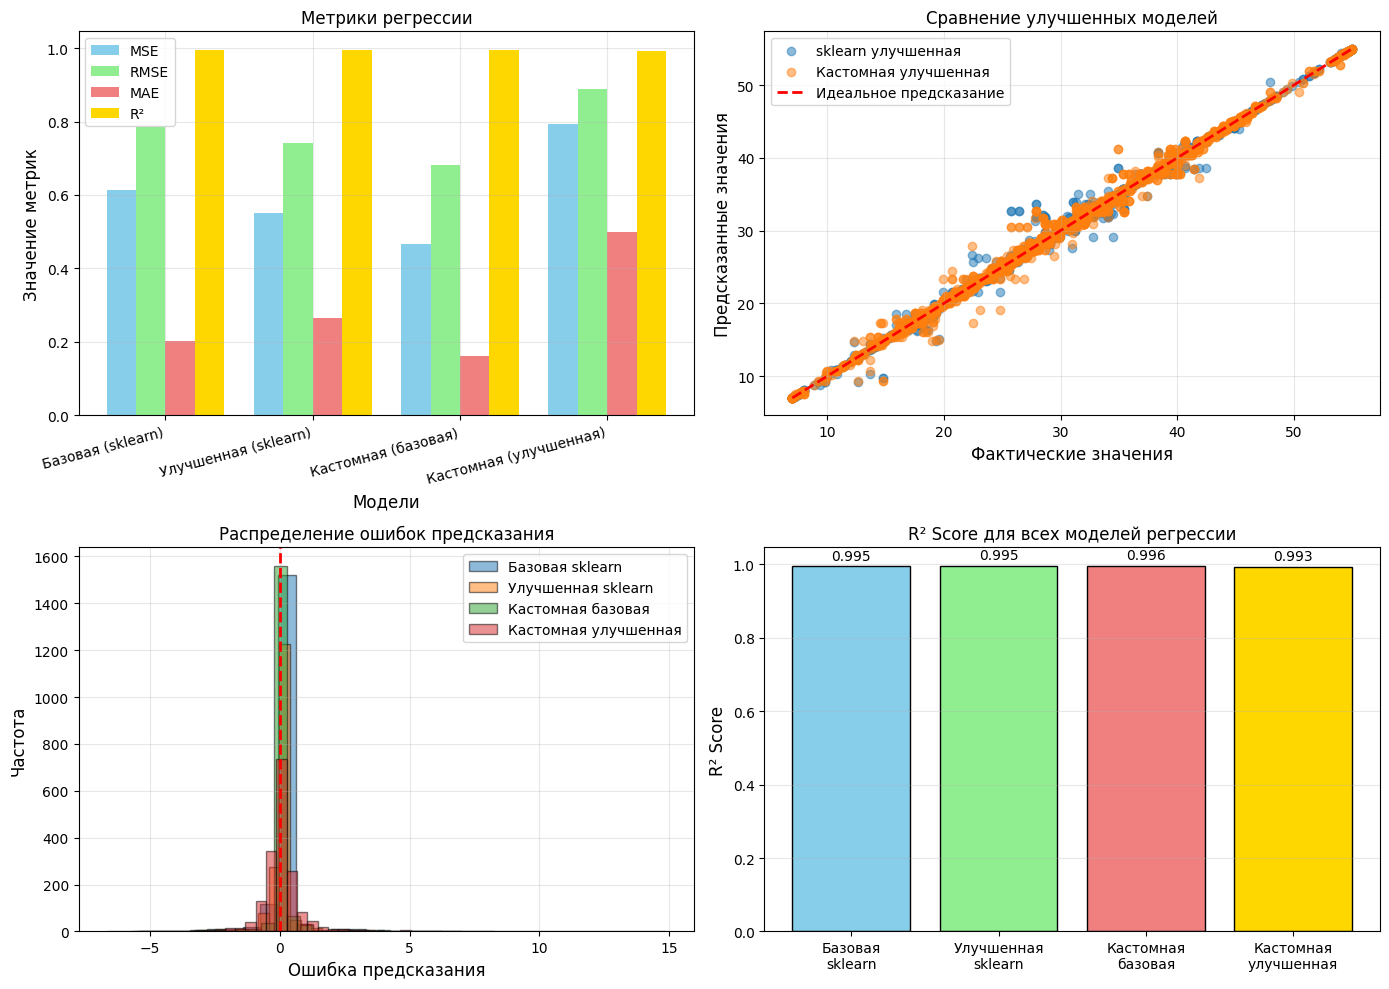

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

x = np.arange(len(summary_reg))
width = 0.2

axes[0, 0].bar(x - width*1.5, summary_reg['MSE'], width, label='MSE', color='skyblue')
axes[0, 0].bar(x - width/2, summary_reg['RMSE'], width, label='RMSE', color='lightgreen')
axes[0, 0].bar(x + width/2, summary_reg['MAE'], width, label='MAE', color='lightcoral')
axes[0, 0].bar(x + width*1.5, summary_reg['R²'], width, label='R²', color='gold')
axes[0, 0].set_xlabel('Модели', fontsize=12)
axes[0, 0].set_ylabel('Значение метрик', fontsize=12)
axes[0, 0].set_title('Метрики регрессии', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(summary_reg['Тип модели'], rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_test_reg, y_pred_improved_reg, alpha=0.5, label='sklearn улучшенная')
axes[0, 1].scatter(y_test_reg, y_pred_imp_custom_reg, alpha=0.5, label='Кастомная улучшенная')
axes[0, 1].plot([y_test_reg.min(), y_test_reg.max()], 
                [y_test_reg.min(), y_test_reg.max()], 
                'r--', lw=2, label='Идеальное предсказание')
axes[0, 1].set_xlabel('Фактические значения', fontsize=12)
axes[0, 1].set_ylabel('Предсказанные значения', fontsize=12)
axes[0, 1].set_title('Сравнение улучшенных моделей', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

errors_base_reg = y_pred_reg - y_test_reg
errors_sklearn_imp = y_pred_improved_reg - y_test_reg
errors_custom_base = y_pred_custom_reg - y_test_reg
errors_custom_imp = y_pred_imp_custom_reg - y_test_reg

axes[1, 0].hist(errors_base_reg, bins=30, alpha=0.5, label='Базовая sklearn', edgecolor='black')
axes[1, 0].hist(errors_sklearn_imp, bins=30, alpha=0.5, label='Улучшенная sklearn', edgecolor='black')
axes[1, 0].hist(errors_custom_base, bins=30, alpha=0.5, label='Кастомная базовая', edgecolor='black')
axes[1, 0].hist(errors_custom_imp, bins=30, alpha=0.5, label='Кастомная улучшенная', edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Ошибка предсказания', fontsize=12)
axes[1, 0].set_ylabel('Частота', fontsize=12)
axes[1, 0].set_title('Распределение ошибок предсказания', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

model_names = ['Базовая\nsklearn', 'Улучшенная\nsklearn', 'Кастомная\nбазовая', 'Кастомная\nулучшенная']
r2_values = [reg_base_metrics['R²'], reg_improved_metrics['R²'], custom_reg_base_metrics['R²'], custom_reg_improved_metrics['R²']]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

axes[1, 1].bar(range(len(model_names)), r2_values, color=colors, edgecolor='black')
axes[1, 1].set_ylabel('R² Score', fontsize=12)
axes[1, 1].set_title('R² Score для всех моделей регрессии', fontsize=12)
axes[1, 1].set_xticks(range(len(model_names)))
axes[1, 1].set_xticklabels(model_names, fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(r2_values):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Выводы и анализ результатов

In [72]:
print("СРАВНЕНИЕ БАЗОВЫХ И КАСТОМНЫХ МОДЕЛЕЙ:")

print("\nКлассификация:")
print("  • Кастомная реализация логистической регрессии показала:")
print(f"    - Accuracy: {custom_class_base_metrics['Accuracy']:.4f} vs {class_base_metrics['Accuracy']:.4f} (sklearn)")
print(f"    - F1-Score: {custom_class_base_metrics['F1']:.4f} vs {class_base_metrics['F1']:.4f} (sklearn)")
print(f"    - Recall:   {custom_class_base_metrics['Recall']:.4f} vs {class_base_metrics['Recall']:.4f} (sklearn)")

print("\nРегрессия:")
print("  • Кастомная реализация линейной регрессии показала:")
print(f"    - R²:  {custom_reg_base_metrics['R²']:.4f} vs {reg_base_metrics['R²']:.4f} (sklearn)")
print(f"    - MSE: {custom_reg_base_metrics['MSE']:.4f} vs {reg_base_metrics['MSE']:.4f} (sklearn)")

print("ЭФФЕКТИВНОСТЬ ТЕХНИК УЛУЧШЕНИЯ:")

print("\nКлассификация:")
print(f"  • Улучшенная кастомная модель vs базовая кастомная:")
print(f"    - F1-Score улучшился: {custom_improved_metrics['F1']:.4f} vs {custom_class_base_metrics['F1']:.4f} (+{custom_improved_metrics['F1'] - custom_class_base_metrics['F1']:.4f})")
print(f"    - Recall улучшился:   {custom_improved_metrics['Recall']:.4f} vs {custom_class_base_metrics['Recall']:.4f} (+{custom_improved_metrics['Recall'] - custom_class_base_metrics['Recall']:.4f})")
print(f"  • Улучшенная кастомная vs улучшенная sklearn:")
print(f"    - F1-Score: {custom_improved_metrics['F1']:.4f} vs {class_improved_metrics['F1']:.4f}")
print(f"    - Recall:   {custom_improved_metrics['Recall']:.4f} vs {class_improved_metrics['Recall']:.4f}")

print("\nРегрессия:")
print(f"  • Улучшенная кастомная модель vs базовая кастомная:")
print(f"    - R² улучшился:  {custom_reg_improved_metrics['R²']:.4f} vs {custom_reg_base_metrics['R²']:.4f} (+{custom_reg_improved_metrics['R²'] - custom_reg_base_metrics['R²']:.4f})")
print(f"    - MSE уменьшился: {custom_reg_improved_metrics['MSE']:.4f} vs {custom_reg_base_metrics['MSE']:.4f} ({custom_reg_base_metrics['MSE'] - custom_reg_improved_metrics['MSE']:.4f})")
print(f"  • Улучшенная кастомная vs улучшенная sklearn:")
print(f"    - R²:  {custom_reg_improved_metrics['R²']:.4f} vs {reg_improved_metrics['R²']:.4f}")
print(f"    - MSE: {custom_reg_improved_metrics['MSE']:.4f} vs {reg_improved_metrics['MSE']:.4f}")

СРАВНЕНИЕ БАЗОВЫХ И КАСТОМНЫХ МОДЕЛЕЙ:

Классификация:
  • Кастомная реализация логистической регрессии показала:
    - Accuracy: 0.8486 vs 0.8554 (sklearn)
    - F1-Score: 0.5189 vs 0.5392 (sklearn)
    - Recall:   0.5280 vs 0.5472 (sklearn)

Регрессия:
  • Кастомная реализация линейной регрессии показала:
    - R²:  0.9959 vs 0.9945 (sklearn)
    - MSE: 0.4663 vs 0.6149 (sklearn)
ЭФФЕКТИВНОСТЬ ТЕХНИК УЛУЧШЕНИЯ:

Классификация:
  • Улучшенная кастомная модель vs базовая кастомная:
    - F1-Score улучшился: 0.5565 vs 0.5189 (+0.0376)
    - Recall улучшился:   0.5035 vs 0.5280 (+-0.0245)
  • Улучшенная кастомная vs улучшенная sklearn:
    - F1-Score: 0.5565 vs 0.5559
    - Recall:   0.5035 vs 0.4913

Регрессия:
  • Улучшенная кастомная модель vs базовая кастомная:
    - R² улучшился:  0.9930 vs 0.9959 (+-0.0029)
    - MSE уменьшился: 0.7920 vs 0.4663 (-0.3257)
  • Улучшенная кастомная vs улучшенная sklearn:
    - R²:  0.9930 vs 0.9951
    - MSE: 0.7920 vs 0.5519
